<a href="https://colab.research.google.com/github/mentorminero/TFM-VIU-Omar-Landa/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Preparación del dataset

#### 1.1. Lectura del conjunto de datos

In [ ]:
from scipy.io import loadmat
data=loadmat("/content/drive/MyDrive/TFM OL/Indian Pines/Indian_pines_corrected_image.mat")['indian_pines_corrected']
labels=loadmat("/content/drive/MyDrive/TFM OL/Indian Pines/Indian_pines_ground_truth.mat")['indian_pines_gt']
H,W,C=data.shape

#### 1.2. Reducción de la dimensionalidad

In [ ]:
from sklearn.decomposition import PCA
n_components=22 # Nuestro análisis abarca 20 bandas
data=data.reshape(H*W,C)
pca=PCA(n_components=n_components,whiten=True)
data=pca.fit_transform(data)

#### 1.3. Normalización de los datos

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standar_scaler=StandardScaler()
data=standar_scaler.fit_transform(data)
data=data.reshape(H,W,n_components);

#### 1.4. Aproximación parche a pixel

In [ ]:
import numpy as np

def padWithZeros(X, margin=2):
    newX=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin, X.shape[2]))
    x_offset=margin
    y_offset=margin 
    newX[x_offset:X.shape[0]+x_offset, y_offset:X.shape[1]+y_offset,:]=X
    return newX

def createImageCubes(X,y,windowSize=9, removeZeroLabels=True): #Regresar a 5
    margin=int((windowSize-1)/2)
    zeroPaddedX=padWithZeros(X,margin=margin)
    patchesData=np.zeros((X.shape[0]*X.shape[1],windowSize,windowSize,X.shape[2]))
    patchesLabels=np.zeros((X.shape[0]*X.shape[1]))
    patchIndex=0
    for r in range(margin,zeroPaddedX.shape[0]-margin):
        for c in range(margin,zeroPaddedX.shape[1]-margin):
            patch=zeroPaddedX[r-margin:r+margin+1,c-margin:c+margin+1]
            patchesData[patchIndex,:,:,:]=patch 
            patchesLabels[patchIndex]=y[r-margin,c-margin]
            patchIndex=patchIndex+1
    if removeZeroLabels:
        patchesData=patchesData[patchesLabels>0,:,:,:]
        patchesLabels=patchesLabels[patchesLabels>0]
        patchesLabels -=1
    from keras.utils import np_utils
    patchesLabels=np_utils.to_categorical(patchesLabels)
    return patchesData,patchesLabels 

#### 1.5. Acondicionar el conjunto de datos

In [ ]:
x_train,y_train=createImageCubes(data,labels,removeZeroLabels=True)

In [ ]:
n_clases=y_train.shape[1]

#### 1.6. Partir Dataset

In [ ]:
# TEST 40%, TRAIN 48%, VALIDATION 12%
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.4,shuffle=True,random_state=0,stratify=y_train) #0.4 100% 0.9--0.79
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,random_state=0,stratify=y_train)

### 2. Red Neuronal Convolucional

In [ ]:
from tensorflow.keras.layers import Input,Conv2D,Dropout,BatchNormalization,Flatten,Dense,LayerNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
shapes=(9,9,n_components)
inputs=Input(shapes)
x=Conv2D(64,(3,3),activation="relu",padding="same")(inputs) # 64 por 60
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation="relu")(x)
x=Dropout(0.2)(x)
x=BatchNormalization()(x)
x=Flatten()(x)
#x=Dense(32,activation="relu")(x) #256 en vez de 243
x=Dropout(0.2)(x)
x=Dense(n_clases,activation="softmax")(x)

model=Model(inputs=inputs,outputs=x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
callback=EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

#### 2.1. Entrenamiento

In [ ]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val,y_val))#,callbacks=[callback])

Epoch 1/100
39/39 [==============================] - 12s 36ms/step - loss: 1.8626 - accuracy: 0.4643 - val_loss: 1.1015 - val_accuracy: 0.6220
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 0.7213 - accuracy: 0.7522 - val_loss: 0.5434 - val_accuracy: 0.8415
Epoch 3/100
39/39 [==============================] - 1s 16ms/step - loss: 0.3819 - accuracy: 0.8729 - val_loss: 0.2827 - val_accuracy: 0.9236
Epoch 4/100
39/39 [==============================] - 1s 14ms/step - loss: 0.2183 - accuracy: 0.9309 - val_loss: 0.1736 - val_accuracy: 0.9520
Epoch 5/100
39/39 [==============================] - 1s 17ms/step - loss: 0.1378 - accuracy: 0.9595 - val_loss: 0.1231 - val_accuracy: 0.9585
Epoch 6/100
39/39 [==============================] - 1s 13ms/step - loss: 0.1066 - accuracy: 0.9661 - val_loss: 0.0640 - val_accuracy: 0.9854
Epoch 7/100
39/39 [==============================] - 1s 16ms/step - loss: 0.0768 - accuracy: 0.9764 - val_loss: 0.0449 - val_accuracy: 0.9894
Epoch

#### 3. Evaluación

#### 3.1. Evaluacion Test

In [ ]:
evaluacion_test=model.evaluate(x_test,y_test)

129/129 [==============================] - 1s 4ms/step - loss: 0.0076 - accuracy: 0.9963


#### 3.2. Classification Report

In [ ]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.metrics import classification_report
clases_dataset_IP=["ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
target_names=clases_dataset_IP
classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
print(classification)

129/129 [==============================] - 0s 2ms/step
                             precision    recall  f1-score   support

                    ALFALFA       1.00      0.89      0.94        19
                CORN-NOTILL       1.00      0.99      1.00       571
               CORN_MINTILL       1.00      1.00      1.00       332
                       CORN       1.00      1.00      1.00        95
              GRASS-PASTURE       0.99      1.00      1.00       193
                GRASS_TREES       0.99      1.00      1.00       292
        GRASS_PASTURE_MOWED       1.00      1.00      1.00        11
              HAY_WINDROWED       1.00      1.00      1.00       191
                       OATS       1.00      1.00      1.00         8
             SOYBEAN_NOTILL       1.00      1.00      1.00       389
            SOYBEAN-MINTILL       1.00      1.00      1.00       982
              SOYBEAN_CLEAN       1.00      0.99      1.00       237
                      WHEAT       1.00      1.0

#### 3.3. Cohen Kappa

In [ ]:
y_pred.shape
y_test.shape

(4100, 16)

In [ ]:
from sklearn.metrics import cohen_kappa_score
a=y_pred
b=np.argmax(y_test,axis=1)
cohen_kappa_score(a,b)

0.9958288739587445

In [ ]:
#np.save("/content/drive/MyDrive/TFM OL/Indian Pines/resultados cnn/a_cnn",evaluacion_test)
#np.save("/content/drive/MyDrive/TFM OL/Indian Pines/resultados cnn/b_cnn",classification)

In [ ]:
y_pred,_=createImageCubes(data,labels,removeZeroLabels=False)
y_pred=model.predict(y_pred,batch_size=128)
y_pred=np.argmax(y_pred,axis=1)
y_pred=y_pred.reshape(H,W)

165/165 [==============================] - 0s 3ms/step


In [ ]:
#np.save("/content/drive/MyDrive/TFM OL/Indian Pines/resultados cnn/c_cnn",y_pred) # Predicción sobre la imagen

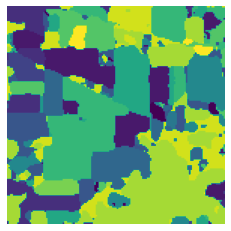

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(y_pred)
plt.axis("off");

In [ ]:
pred_gt=y_pred+np.ones_like(y_pred)

In [ ]:
mask=np.array([labels])>0 # Generamos máscaras.
mask=mask.astype("uint8")
pred_gt=mask*pred_gt
pred_gt=pred_gt.reshape(data.shape[0],data.shape[1])

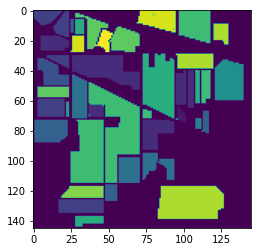

In [ ]:
plt.imshow(pred_gt)

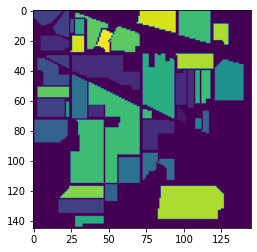

In [ ]:
plt.imshow(labels)

In [ ]:
from keras.metrics import MeanIoU 
n_classes=17
IOU_mean=MeanIoU(num_classes=n_classes)
IOU_mean.update_state(pred_gt,labels)
print("Mean IoU",IOU_mean.result().numpy())

Mean IoU 0.9931296


In [ ]:
# Mean IoU
from keras.metrics import MeanIoU 
IOU_mean=MeanIoU(num_classes=17)
IOU_mean.update_state(pred_gt,labels)
print("Mean IoU",IOU_mean.result().numpy())

Mean IoU 0.9931296


In [ ]:
a=pred_gt.reshape(H*W)
b=labels.reshape(H*W)
cohen_kappa_score(a,b)

0.9986566193250584

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(a,b)

0.9990487514863258

In [ ]:
#np.save("/content/drive/MyDrive/TFM OL/Indian Pines/resultados cnn/d_cnn",IOU_mean.result().numpy()) # MeanIoU

In [ ]:
# IoU por clase.
from keras.metrics import IoU
clases=["unlabeled","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
IoU_class_report=[]
for i in range(17):
    IoU_class=IoU(num_classes=17,target_class_ids=[i])
    IoU_class.update_state(pred_gt,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(clases[i],":", IoU_class.result().numpy())
#np.save("/content/drive/MyDrive/TFM OL/Indian Pines/resultados cnn/e_cnn",IoU_class_report)

unlabeled : 1.0
ALFALFA : 0.95652175
CORN-NOTILL : 0.99720085
CORN_MINTILL : 0.99879664
CORN : 1.0
GRASS-PASTURE : 0.99793386
GRASS_TREES : 0.9972678
GRASS_PASTURE_MOWED : 1.0
HAY_WINDROWED : 1.0
OATS : 1.0
SOYBEAN_NOTILL : 0.9979445
SOYBEAN-MINTILL : 0.9987785
SOYBEAN_CLEAN : 0.99662733
WHEAT : 0.99512196
WOODS : 0.9913793
BUILDING_GRASS_TREES_DRIVES : 0.9766839
STONE_STEEL_TOWERS : 0.97894734


In [ ]:
#model.save("/content/drive/MyDrive/TFM OL/Indian Pines/resultados cnn/f_cnn.h5")